The problem definition is that we have a sequence of images and we need to predict a sequence of steering wheel angles . So this is a type of regression problem .

For simplicity , we will pose the problem as predicting a steering wheel angle(some real value) given an image . i.e. a CNN - regression problem .

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


Mounting google drive to use the data directly in colab

In [3]:
!unzip /content/drive/MyDrive/dataset.zip

Archive:  /content/drive/MyDrive/dataset.zip
   creating: dataset/
  inflating: dataset/0.jpg           
  inflating: dataset/1.jpg           
  inflating: dataset/2.jpg           
  inflating: dataset/3.jpg           
  inflating: dataset/4.jpg           
  inflating: dataset/5.jpg           
  inflating: dataset/6.jpg           
  inflating: dataset/7.jpg           
  inflating: dataset/8.jpg           
  inflating: dataset/9.jpg           
  inflating: dataset/10.jpg          
  inflating: dataset/11.jpg          
  inflating: dataset/12.jpg          
  inflating: dataset/13.jpg          
  inflating: dataset/14.jpg          
  inflating: dataset/15.jpg          
  inflating: dataset/16.jpg          
  inflating: dataset/17.jpg          
  inflating: dataset/18.jpg          
  inflating: dataset/19.jpg          
  inflating: dataset/20.jpg          
  inflating: dataset/21.jpg          
  inflating: dataset/22.jpg          
  inflating: dataset/23.jpg          
  inflating: dataset/

Extracted the data folder

In [134]:
import torch
import torch.nn as nn 
import torch.optim as optim  
import torchvision.transforms as transforms
import torchvision
import os
import pandas as pd
from PIL import Image
from torch.utils.data import (
    Dataset,
    DataLoader,
)

Imported necessary libraries

In [135]:
class RegressionDataset(Dataset):
    def __init__(self, txt_file, root_dir, transform=None):
        with open(txt_file) as f:
            self.data = f.readlines()
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        line = self.data[index].strip().split()
        img_path = os.path.join(self.root_dir, line[0])
        image = Image.open(img_path)
        target = float(line[1])

        if self.transform:
            image = self.transform(image)

        return (image, target)

Constructed custom dataset for loading data

In [136]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Necessary transformations on image

In [137]:
dataset = RegressionDataset(
    txt_file="data.txt",
    root_dir="driving_dataset",
    transform=transform
)

In [27]:
'''dataloader = DataLoader(
    dataset,
    batch_size=10,
    shuffle=True,
    num_workers=1,
)'''

In [138]:
from torch.utils.data import random_split

train_dataset, test_dataset = random_split(dataset, [int(len(dataset) * 0.8), len(dataset) - int(len(dataset) * 0.8)])

train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False)

Splitted the data with 80% as train data and 20% as test data  then constructed data loader for both train and test dataset

In [139]:
images , targets = next(iter(train_dataloader))

In [140]:
images.shape

torch.Size([50, 3, 256, 256])

In [141]:
targets.shape

torch.Size([50])

labels : tensor([ 3.7300e+00, -2.4000e+01,  1.4592e+02,  0.0000e+00, -2.0570e+01,
         1.3100e+00, -1.3734e+02,  5.7880e+01,  2.4710e+01, -1.4100e+00,
         1.8150e+01, -1.9460e+01,  1.3753e+02,  1.6100e+00,  7.3600e+00,
         0.0000e+00,  0.0000e+00,  1.7450e+01, -1.1190e+01, -2.0270e+01,
        -1.4100e+00, -1.6340e+01, -1.8760e+01,  1.5430e+01, -1.0690e+01,
        -1.9060e+01,  2.7530e+01,  2.3800e+01, -1.7100e+00, -2.5200e+00,
         1.2000e+01,  0.0000e+00,  2.4200e+00,  4.1950e+01,  1.0000e-01,
         1.6440e+01,  2.3800e+01,  2.8200e+00, -1.6740e+01,  3.0300e+00,
         1.4420e+01,  0.0000e+00, -3.0000e-01,  3.2300e+00, -1.7450e+01,
         5.0000e-01,  7.2600e+00,  1.5330e+01, -1.4100e+00,  1.0100e+00],
       dtype=torch.float64)


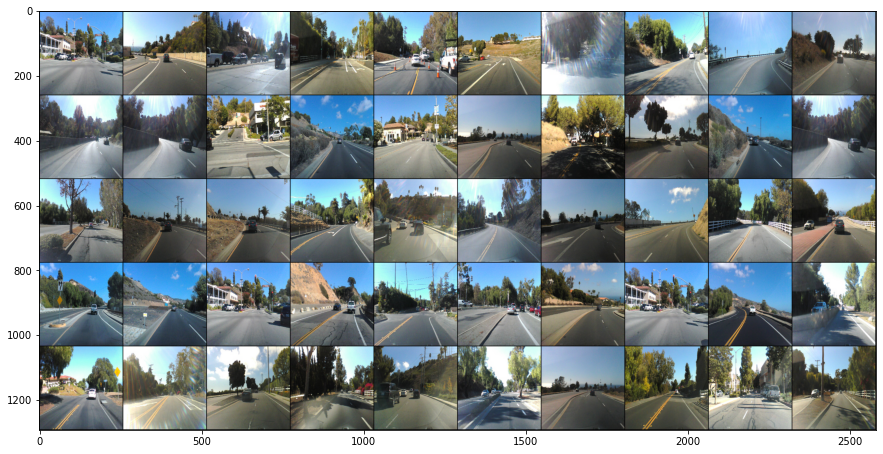

In [142]:
import numpy as np
import matplotlib.pyplot as plt
grid = torchvision.utils.make_grid(images,nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)))
print(f"labels : {targets}")

Visualization of our images

In [143]:
class CustomNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(32, 64, kernel_size = 2, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Linear(64 ,28),
            nn.ReLU(),
            nn.Linear(28,1)
        )
    
    def forward(self, xb):
        return self.network(xb)

Buiding our custom network

In [144]:
network = CustomNetwork()
print(network)

CustomNetwork(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Linear(in_features=64, out_features=28, bias=True)
    (7): ReLU()
    (8): Linear(in_features=28, out_features=1, bias=True)
  )
)


Created an instance of our custom network

In [146]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.1)

for epoch in range(5):
    total_loss = 0
    for item in train_dataloader:
        images , targets = next(iter(train_dataloader))
        #targets = targets.float()
        targets = targets.view(-1, 1, 1, 1).float()
        #targets = torch.tensor(targets).view(-1, *images.shape[1:])

        preds = network(images)
        loss = criterion(preds, targets)

        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    avg_loss = total_loss / len(train_dataloader)
    print("epoch:",epoch,"loss:",avg_loss)

KeyboardInterrupt: 

Training for a few epochs .
Everything is running well .

In [13]:
torch.save(network.state_dict(), 'model.pth')

In [160]:
state_dict = torch.load('model.pth')

In [161]:
class MyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 24, kernel_size = 5, stride = 2 ),
            nn.ELU(),
        
            nn.Conv2d(24, 36, kernel_size = 5, stride = 2),
            nn.ELU(),

            nn.Conv2d(36, 48, kernel_size = 5, stride = 2),
            nn.ELU(),

            nn.Conv2d(48, 64, kernel_size = 3, stride = 1 ),
            nn.ELU(),

            nn.Conv2d(64, 64, kernel_size = 3, stride = 1),
            nn.ELU(),

            nn.Dropout(0.5),
            
            nn.Linear(25,100),
            nn.ELU(),

            nn.Linear(100,50),
            nn.ELU(),

            nn.Linear(50,10),
            #nn.ELU(),

            nn.Linear(10,1),
        )
    
    def forward(self, xb):
        return self.network(xb)

In [162]:
network = torch.load("/home/pranjal-ubuntu/Downloads/model.pt")

In [163]:

import tensorflow as tf
import os 
import scipy.misc
from scipy import pi
import cv2
from subprocess import call
import math
smoothed_angle = 0
xs = []
ys = []

In [182]:

img = cv2.imread('car.jpg',0)
#rows,cols,channels = img.shape

In [165]:
rows,cols = img.shape

In [166]:
print(rows)
print(cols)

638
640


In [168]:
with open("data.txt") as f:
    for line in f:
        xs.append("driving_dataset" + line.split()[0])
        ys.append(float(line.split()[1]) * scipy.pi / 180)

In [169]:
num_images = len(xs)
print(num_images)

45447


In [170]:
import math
i = math.ceil(num_images*0.7)
print("Starting frameofvideo:" +str(i))

Starting frameofvideo:31813


In [174]:
network.to("cpu")

MyNetwork(
  (network): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (3): ELU(alpha=1.0)
    (4): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (5): ELU(alpha=1.0)
    (6): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ELU(alpha=1.0)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ELU(alpha=1.0)
    (10): Dropout(p=0.5, inplace=False)
    (11): Linear(in_features=25, out_features=100, bias=True)
    (12): ELU(alpha=1.0)
    (13): Linear(in_features=100, out_features=50, bias=True)
    (14): ELU(alpha=1.0)
    (15): Linear(in_features=50, out_features=10, bias=True)
    (16): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [192]:

for i in range(num_images):
    full_image = cv2.imread("driving_dataset/" + str(i) + ".jpg", cv2.IMREAD_COLOR)
    image = cv2.resize(full_image, (256, 256))
    #image = np.array(image)
    cv2.imshow("image",image)
    image = torch.from_numpy(image)
    image = image.float()
    image = image.reshape(1, 3, 256, 256)
    predicted = network(image)
    #cv2.waitKey(1)
    smoothed_angle += 0.3 * pow(abs((predicted - smoothed_angle)), 2.0 / 3.0) * (predicted - smoothed_angle) / abs(predicted - smoothed_angle)
    #smoothed_angle = smoothed_angle.float()
    #smoothed_angle = smoothed_angle * math.pi / 180
    print(smoothed_angle)

    smoothed_angle = smoothed_angle[0][0][0][0].item()
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering", dst)
    cv2.waitKey(1)
    i = i+1


tensor([[[[-54.2973],
          [-52.5488],
          [-53.9694],
          ...,
          [-52.5639],
          [-55.4432],
          [-52.0127]],

         [[-51.3715],
          [-52.7679],
          [-54.5051],
          ...,
          [-55.3164],
          [-52.9551],
          [-55.2865]],

         [[-51.6414],
          [-51.1685],
          [-52.3099],
          ...,
          [-55.0456],
          [-53.0316],
          [-54.5824]],

         ...,

         [[-55.7669],
          [-52.3177],
          [-55.3295],
          ...,
          [-54.5926],
          [-52.8502],
          [-55.2831]],

         [[-54.2180],
          [-53.6000],
          [-53.3524],
          ...,
          [-54.0569],
          [-54.3299],
          [-55.5939]],

         [[-55.3138],
          [-54.8077],
          [-54.6697],
          ...,
          [-55.5901],
          [-52.3201],
          [-55.2840]]]], grad_fn=<AddBackward0>)
tensor([[[[-56.5996],
          [-55.7266],
          [-52.3049],


KeyboardInterrupt: 

In [193]:
cv2.destroyWindow("steering")

In [194]:
cv2.destroyWindow("image")